Extracting Data of Class: cover
Extracting Data of Class: defense
Extracting Data of Class: flick
0.4733296350161996


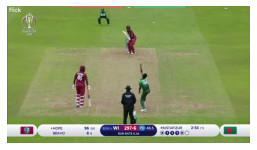

In [2]:
import os #Sindh
import cv2
import math
import random
#import pafy
#import youtube_dl
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from sklearn.model_selection import KFold
from keras.layers import Dense, Dropout, Flatten, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv3D, MaxPooling3D, Flatten, LSTM, concatenate
from tensorflow.keras.layers import Reshape

seed_constant = 27 #Sindh
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

dataset = './temps/' #Sindh(Dataset path change karna pc pai jo ayega)

plt.figure(figsize = (20, 20))  #Sindh
 
#Get the names of all shots/categories in dataset.
#all_classes_names = ['cover', 'defense' , 'flick','hook','late_cut','lofted','pull','square_cut','straight','sweep']
all_classes_names = ['cover', 'defense' , 'flick']

 
for classes in all_classes_names:
 
    #selected_class_Name = classes
 
    # Retrieving the list of all the video files present in shot Directories.
    video_files_names_list = os.listdir(f'{dataset}/{classes}')
 
    # Randomly selecting a video file from the list retrieved video files names list.
    selected_video_file_name = random.choice(video_files_names_list)
 
    video_reader = cv2.VideoCapture(f'{dataset}/{classes}/{selected_video_file_name}')
    
    _, bgr_frame = video_reader.read()
 
    video_reader.release()
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, classes, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, 4);plt.imshow(rgb_frame);plt.axis('off')
# Specifying the height and width to which each video frame will be resized in our dataset.  #Sindh
IMAGE_HEIGHT , IMAGE_WIDTH = 180, 180  

# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specifying the directory containing the dataset. 
DATASET_DIR = dataset

# Specifying the list containing the names of the classes used for training.
#CLASSES_LIST = ['cover', 'defense' , 'flick','hook','late_cut','lofted','pull','square_cut','straight','sweep']
CLASSES_LIST = ['cover', 'defense' , 'flick']

#**Extracting frames from videos**
def frames_extraction(video_path):  #Sindh
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        # Setting the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Checking if Video frame is not successfully read then break the loop
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalizing the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

def create_dataset():  #Sindh
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            # Getting the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extracting the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Checking if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

features, labels, video_files_paths = create_dataset()  #Sindh
mean_image = np.mean(features)
print(mean_image)
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)  #Sindh
# Split the Data into Train ( 90% ) and Test Set ( 10% ).   #Sindh
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = seed_constant)
class MemoryPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gpu_dict = tf.config.experimental.get_memory_info('GPU:0')
        tf.print('\n GPU memory details [current: {} gb, peak: {} gb]'.format(
            float(gpu_dict['current']) / (1024 ** 3), 
            float(gpu_dict['peak']) / (1024 ** 3)))

In [3]:
def create_3D_CNN():   #Sindh
  '''
    This function will construct the required 3DCNN model.
    Returns:
        model: It is the required constructed 3DCNN model.
  '''

  # Defining the Model Architecture.
    ########################################################################################################################

  input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

  inputs = Input(shape=input_shape)

  x = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(inputs)
  
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)
  
  x = (TimeDistributed(Dropout(0.2)))(x)
  
  x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(x)
  
  x = MaxPooling3D(pool_size=(2, 2, 2))(x)

  x = Flatten()(x)

  outputs = Dense(units=len(CLASSES_LIST), activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  ########################################################################################################################

  model.summary()

  return model


CNN3D_model = create_3D_CNN()   #Sindh
print("Model Created Successfully!")

plot_model(CNN3D_model, to_file = 'CNN3D_model_structure_plot.png', show_shapes = True, show_layer_names = True)   #Sindh

CNN3D_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   #Sindh
# Define the number of folds for cross-validation
k = 5            #Sindh

# Load your 3D data here
X = features_train
y = labels_train

# Define the K-fold cross-validator
kf = KFold(n_splits=k)
# Iterate over each fold                  #Sindh
for i, (train_index, val_index) in enumerate(kf.split(X)):
    
    print(f'Fold {i+1}/{k}')
    
    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Fit the model on the training set for this fold
    CNN3D_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val), callbacks= [MemoryPrintingCallback()])    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 180, 180, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 8, 178, 178, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 89, 89, 32)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 4, 89, 89, 32)    0         
 ibuted)                                                         
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 87, 87, 64)     55360     
                                                             

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.